<a href="https://colab.research.google.com/github/juanmqc22/IAparaDevs-TechChallenge1/blob/main/ExtraTechChallenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Introdução

Este notebook implementa um modelo de classificação de imagens de raio-X de tórax.

O objetivo é distinguir entre imagens normais e com pneumonia, avaliando o desempenho do modelo em termos de acurácia, loss e métricas de classificação.

Dataset: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

# Notebook
### Importando Bibliotecas





In [8]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import itertools
import pandas as pd

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report


In [9]:
from google.colab import drive
drive.mount('/content/drive')

BASE_DIR = '/content/drive/MyDrive/Database IA/chest_xray'
train_dir = os.path.join(BASE_DIR, 'train')
val_dir   = os.path.join(BASE_DIR, 'val')
test_dir  = os.path.join(BASE_DIR, 'test')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Análise Exploratória de Dados (EDA)

In [10]:
## Contagem de imagens por classe

def contar_imagens_por_classe(base_dir):
    dados = []
    for subset in ['train', 'val', 'test']:
        subset_path = os.path.join(base_dir, subset)
        for classe in os.listdir(subset_path):
            classe_path = os.path.join(subset_path, classe)
            if os.path.isdir(classe_path):
                qtd = len(os.listdir(classe_path))
                dados.append({'Conjunto': subset, 'Classe': classe, 'Quantidade': qtd})
    return pd.DataFrame(dados)

df_classes = contar_imagens_por_classe(BASE_DIR)
df_classes


,Conjunto,Classe,Quantidade
0,train,PNEUMONIA,3489
1,train,NORMAL,1208
2,val,PNEUMONIA,396
3,val,NORMAL,143
4,test,PNEUMONIA,390
5,test,NORMAL,234


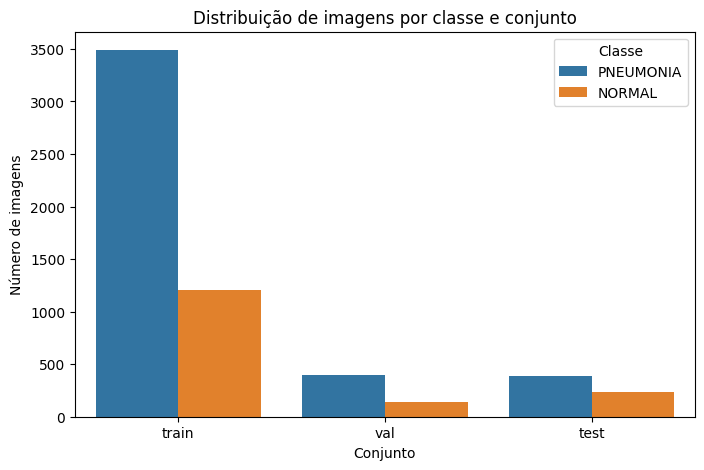

In [11]:
## Distribuição de imagens por classe e conjunto

plt.figure(figsize=(8,5))
sns.barplot(data=df_classes, x='Conjunto', y='Quantidade', hue='Classe')
plt.title('Distribuição de imagens por classe e conjunto')
plt.xlabel('Conjunto')
plt.ylabel('Número de imagens')
plt.show()

Observações:

Há muito mais imagens de PNEUMONIA que de NORMAL, mostrando desbalanceamento de classes.

Esse desbalanceamento será considerado no treino usando data augmentation e shuffle, ajudando a equilibrar a exposição do modelo às duas classes.

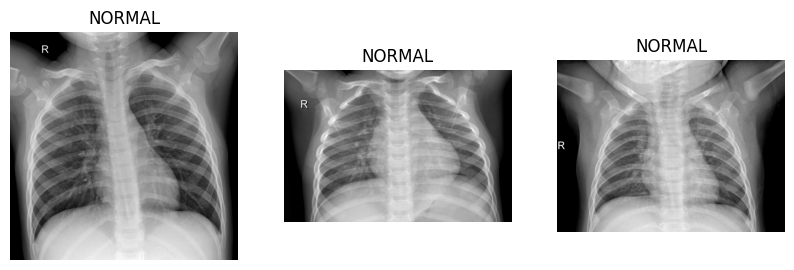

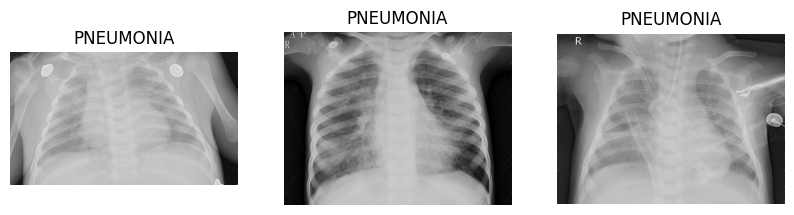

In [12]:
## Exemplo de imagens do dataset

import matplotlib.image as mpimg

def mostrar_exemplos(base_dir, classe, n=3):
    caminho = os.path.join(base_dir, 'train', classe)
    imagens = random.sample(os.listdir(caminho), n)
    plt.figure(figsize=(10,3))
    for i, img_name in enumerate(imagens):
        img_path = os.path.join(caminho, img_name)
        img = mpimg.imread(img_path)
        plt.subplot(1, n, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(classe)
        plt.axis('off')
    plt.show()

mostrar_exemplos(BASE_DIR, 'NORMAL')
mostrar_exemplos(BASE_DIR, 'PNEUMONIA')


In [13]:
## Verificação de tamanhos médios de imagens

sizes = []
for classe in ['NORMAL', 'PNEUMONIA']:
    caminho = os.path.join(train_dir, classe)
    for img_name in os.listdir(caminho)[:200]:
        img_path = os.path.join(caminho, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            sizes.append(img.shape[:2])

heights, widths = zip(*sizes)
print(f"Tamanho médio: {np.mean(heights):.1f} x {np.mean(widths):.1f}")


Tamanho médio: 1103.3 x 1433.1


## Pré-processamento e Data Augmentation (mitigando desbalanceamento)

In [14]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

IMG_SIZE = (224,224)
BATCH_SIZE = 32

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

val_gen = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_gen = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


Found 4695 images belonging to 2 classes.
Found 537 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Construção do Modelo – Transfer Learning com MobileNetV2

In [15]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Callbacks e Treinamento Inicial

In [16]:
callbacks = [
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss'),
    EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=callbacks
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8801 - loss: 0.2776

147/147 ━━━━━━━━━━━━━━━━━━━━ 1067s 7s/step - accuracy: 0.8804 - loss: 0.2770 - val_accuracy: 0.9367 - val_loss: 0.1405 - learning_rate: 0.0010
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9564 - loss: 0.1217

147/147 ━━━━━━━━━━━━━━━━━━━━ 349s 2s/step - accuracy: 0.9564 - loss: 0.1217 - val_accuracy: 0.9479 - val_loss: 0.1231 - learning_rate: 0.0010
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9565 - loss: 0.1116

147/147 ━━━━━━━━━━━━━━━━━━━━ 347s 2s/step - accuracy: 0.9565 - loss: 0.1116 - val_accuracy: 0.9721 - val_loss: 0.0742 - learning_rate: 0.0010
Epoch 4/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 348s 2s/step - accuracy: 0.9611 - loss: 0.1030 - val_accuracy: 0.9665 - val_loss: 0.0786 - learning_rate: 0.0010
Epoch 5/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 349s 2s/step - accuracy: 0.9659 - loss: 0.0915 - val_accuracy: 0.9460 - val_loss: 0.1379 - learning_rate: 0.0010
Epoch 6/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 373s 2s/step - accuracy: 0.9601 - loss: 0.1062 - val_accuracy: 0.9646 - val_loss: 0.0782 - learning_rate: 0.0010
Epoch 7/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9606 - loss: 0.0899

147/147 ━━━━━━━━━━━━━━━━━━━━ 392s 2s/step - accuracy: 0.9606 - loss: 0.0898 - val_accuracy: 0.9665 - val_loss: 0.0722 - learning_rate: 5.0000e-04
Epoch 8/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9730 - loss: 0.0760

147/147 ━━━━━━━━━━━━━━━━━━━━ 339s 2s/step - accuracy: 0.9730 - loss: 0.0760 - val_accuracy: 0.9683 - val_loss: 0.0702 - learning_rate: 5.0000e-04
Epoch 9/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 348s 2s/step - accuracy: 0.9676 - loss: 0.0810 - val_accuracy: 0.9702 - val_loss: 0.0735 - learning_rate: 5.0000e-04
Epoch 10/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9725 - loss: 0.0681

147/147 ━━━━━━━━━━━━━━━━━━━━ 339s 2s/step - accuracy: 0.9725 - loss: 0.0681 - val_accuracy: 0.9702 - val_loss: 0.0678 - learning_rate: 5.0000e-04


## Fine-Tuning (Últimas camadas)

In [18]:
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_ft = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    callbacks=callbacks
)


Epoch 1/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 460s 3s/step - accuracy: 0.9743 - loss: 0.0919 - val_accuracy: 0.9814 - val_loss: 0.2360 - learning_rate: 0.0010
Epoch 2/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 436s 3s/step - accuracy: 0.9791 - loss: 0.0717 - val_accuracy: 0.9702 - val_loss: 0.1684 - learning_rate: 0.0010
Epoch 3/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 414s 3s/step - accuracy: 0.9867 - loss: 0.0469 - val_accuracy: 0.9665 - val_loss: 0.2693 - learning_rate: 0.0010
Epoch 4/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 424s 3s/step - accuracy: 0.9811 - loss: 0.0486 - val_accuracy: 0.9553 - val_loss: 0.3593 - learning_rate: 0.0010
Epoch 5/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 428s 3s/step - accuracy: 0.9830 - loss: 0.0412 - val_accuracy: 0.9292 - val_loss: 0.5634 - learning_rate: 0.0010


## Avaliação no Conjunto de Teste

In [19]:
test_loss, test_acc = model.evaluate(test_gen, verbose=2)
print(f"\n📈 Teste — Loss: {test_loss:.4f}, Acurácia: {test_acc:.4f}")


20/20 - 293s - 15s/step - accuracy: 0.8317 - loss: 4.2676

📈 Teste — Loss: 4.2676, Acurácia: 0.8317


## Interpretação dos Resultados

NORMAL:	O modelo acerta quase sempre quando prevê NORMAL, mas perde alguns casos (falsos positivos para pneumonia).

PNEUMONIA: O modelo detecta praticamente todas as pneumonias, com alguns falsos positivos.


Acurácia geral: 83%

Tendência: O modelo prioriza a detecção de Pneumonia (alto recall), o que é desejável em um contexto médico — é melhor revisar um falso positivo do que deixar um caso passar despercebido.

## Visualização do Treinamento

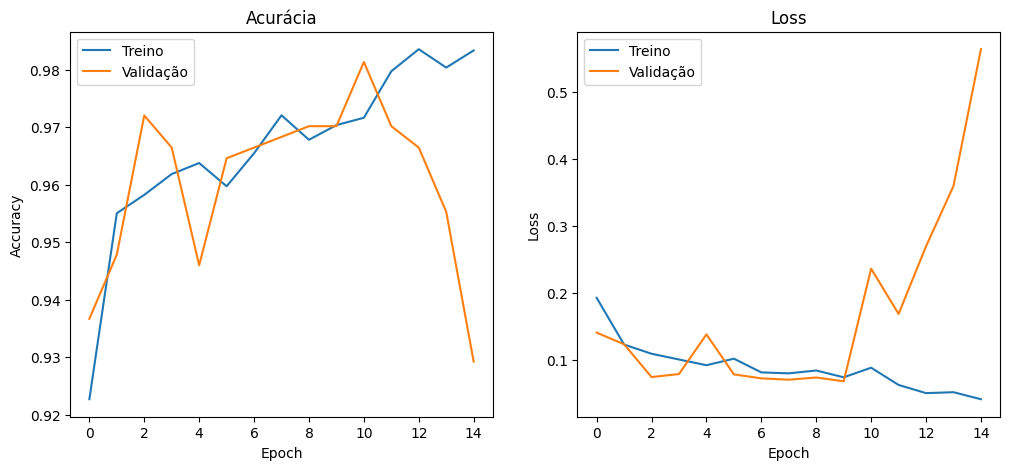

In [20]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'] + history_ft.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'] + history_ft.history['val_accuracy'], label='Validação')
plt.title('Acurácia')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'] + history_ft.history['loss'], label='Treino')
plt.plot(history.history['val_loss'] + history_ft.history['val_loss'], label='Validação')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


## Relatório de Classificação e Matriz de Confusão

20/20 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step

📊 Relatório de Classificação:

              precision    recall  f1-score   support

      NORMAL       0.99      0.56      0.71       234
   PNEUMONIA       0.79      1.00      0.88       390

    accuracy                           0.83       624
   macro avg       0.89      0.78      0.80       624
weighted avg       0.87      0.83      0.82       624



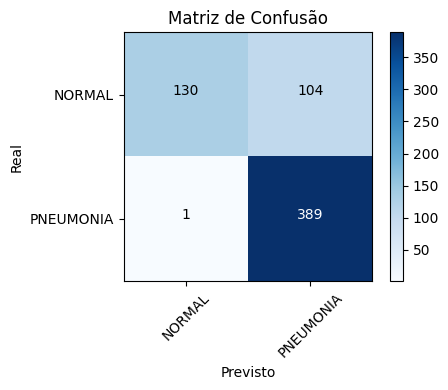

In [21]:
Y_pred = model.predict(test_gen)
y_pred = (Y_pred > 0.5).astype(int).flatten()
y_true = test_gen.classes

print("\n📊 Relatório de Classificação:\n")
print(classification_report(y_true, y_pred, target_names=list(test_gen.class_indices.keys())))

cm = confusion_matrix(y_true, y_pred)
classes = list(test_gen.class_indices.keys())

plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Matriz de Confusão")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Real')
plt.xlabel('Previsto')
plt.tight_layout()
plt.show()


## Visualização de Previsões (Acertos e Erros)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


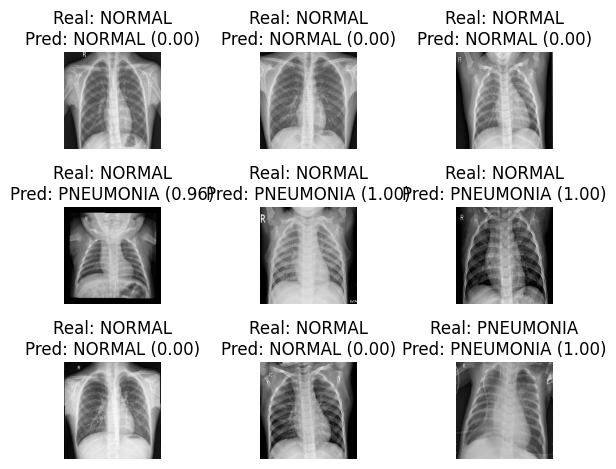

In [24]:
for i in range(9):
    img, label = test_gen[i][0][0], test_gen[i][1][0]
    pred = model.predict(np.expand_dims(img, axis=0))[0][0]
    plt.subplot(3, 3, i+1)
    plt.imshow((img * 127.5 + 127.5).astype(np.uint8))
    plt.title(f"Real: {'PNEUMONIA' if label==1 else 'NORMAL'}\nPred: {'PNEUMONIA' if pred>0.5 else 'NORMAL'} ({pred:.2f})")
    plt.axis('off')
plt.tight_layout()
plt.show()
